In [1]:
%%capture
!pip install bertopic

In [2]:
import itertools, ast, re, nltk
import numpy as np
import pandas as pd
import networkx as nx
import copy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk import bigrams
from bertopic import BERTopic

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
FOLDER_PATH = '/content/drive/MyDrive/Knowledge Graphs 2022/'
%cd $FOLDER_PATH

/content/drive/.shortcut-targets-by-id/18wZgIc4f2VuuQ34uv_vRrBAOHvMWSEaq/Knowledge Graphs 2022


In [5]:
topic_model = BERTopic.load('topic modeling/qanon_tweets_50_topics.model')

In [6]:
tweets_w_cleaned_setence = pd.read_csv('data/tweets_cleaned_sentence.csv')
tweets_w_cleaned_setence.columns = ['id', 'text', 'time', 'user_id', 'user_screen_name', 'raw_cleaned_text']
tweets_w_cleaned_setence = tweets_w_cleaned_setence.fillna('')
tweets_w_cleaned_setence

,id,text,time,user_id,user_screen_name,raw_cleaned_text
0,1420959115879145474,https://t.co/3bM9PoSxS6 #acoustic #orchestra #...,Fri Jul 30 04:07:08 +0000 2021,1404563992907976706,teknoaxe,
1,1420589578541428739,@DekeSlade Hey Rj! A link to my youtube chann...,Thu Jul 29 03:38:43 +0000 2021,1404563992907976706,teknoaxe,Hey Rj! A link to my youtube channel or the v...
2,1420533067400105985,@kraftoki @MinxMore How do you know?,Wed Jul 28 23:54:10 +0000 2021,1404563992907976706,teknoaxe,How do you know?
3,1420373718828679174,"@MinxMore Also, consider that ""immune for only...",Wed Jul 28 13:20:58 +0000 2021,1404563992907976706,teknoaxe,"Also, consider that immune for only a few mont..."
4,1420373378653773829,@MinxMore It's like chicken pox....,Wed Jul 28 13:19:37 +0000 2021,1404563992907976706,teknoaxe,Its like chicken pox....
...,...,...,...,...,...,...
923380,1397974274367963136,@Baklava_in_CA @jordanbpeterson I got my pound.,Thu May 27 17:53:34 +0000 2021,218741203,mml111mml111,I got my pound.
923381,1397972983067693064,@nypost He tries to turn his hotel rooms into ...,Thu May 27 17:48:26 +0000 2021,218741203,mml111mml111,He tries to turn his hotel rooms into Vermont?
923382,1397972391708475392,@Baklava_in_CA @jordanbpeterson I've realized ...,Thu May 27 17:46:05 +0000 2021,218741203,mml111mml111,Ive realized we are never going to pay that de...
923383,1397813255523995648,"So, what do you think the long term side effec...",Thu May 27 07:13:44 +0000 2021,218741203,mml111mml111,"So, what do you think the long term side effec..."


In [7]:
all_tweets_df = pd.read_csv('data/tweets_cleaned_text.csv')
all_tweets_df = all_tweets_df.merge(tweets_w_cleaned_setence[['id', 'user_id', 'raw_cleaned_text']], on='id')
all_tweets_df['cleaned_text'] = all_tweets_df['cleaned_text'].apply(lambda x: ast.literal_eval(x))
all_tweets_df

,id,text,time,cleaned_text,user_id,raw_cleaned_text
0,1420959115879145474,https://t.co/3bM9PoSxS6 #acoustic #orchestra #...,Fri Jul 30 04:07:08 +0000 2021,[],1404563992907976706,
1,1420589578541428739,@DekeSlade Hey Rj! A link to my youtube chann...,Thu Jul 29 03:38:43 +0000 2021,"[youtube, channel, video, music, feature, good...",1404563992907976706,Hey Rj! A link to my youtube channel or the v...
2,1420533067400105985,@kraftoki @MinxMore How do you know?,Wed Jul 28 23:54:10 +0000 2021,[know],1404563992907976706,How do you know?
3,1420373718828679174,"@MinxMore Also, consider that ""immune for only...",Wed Jul 28 13:20:58 +0000 2021,"[consider, immune, month, come, journalist, po...",1404563992907976706,"Also, consider that immune for only a few mont..."
4,1420373378653773829,@MinxMore It's like chicken pox....,Wed Jul 28 13:19:37 +0000 2021,[chicken],1404563992907976706,Its like chicken pox....
...,...,...,...,...,...,...
923380,1397974274367963136,@Baklava_in_CA @jordanbpeterson I got my pound.,Thu May 27 17:53:34 +0000 2021,[pound],218741203,I got my pound.
923381,1397972983067693064,@nypost He tries to turn his hotel rooms into ...,Thu May 27 17:48:26 +0000 2021,"[turn, hotel, room, vermont]",218741203,He tries to turn his hotel rooms into Vermont?
923382,1397972391708475392,@Baklava_in_CA @jordanbpeterson I've realized ...,Thu May 27 17:46:05 +0000 2021,"[realize, never, debt, alone, interest, centra...",218741203,Ive realized we are never going to pay that de...
923383,1397813255523995648,"So, what do you think the long term side effec...",Thu May 27 07:13:44 +0000 2021,"[think, long, term, side, effect]",218741203,"So, what do you think the long term side effec..."


In [8]:
active_users_list = pd.read_csv('filtered users/filtered_users.csv', header=None).to_numpy().flatten()

## Topic Co-occurrence Network

In [9]:
user_tweets_df = all_tweets_df[all_tweets_df['user_id'].isin(active_users_list)].reset_index().drop(columns='index')
user_tweets_df

,id,text,time,cleaned_text,user_id,raw_cleaned_text
0,1420964843302101002,George C Scott fucking owned,Fri Jul 30 04:29:53 +0000 2021,"[george, scott]",83897126,George C Scott fucking owned
1,1420915480144093185,@Morgis_Red @Dok845 Don't make me tap the sign,Fri Jul 30 01:13:44 +0000 2021,"[dont, make, sign]",83897126,Dont make me tap the sign
2,1420914767976452098,"@Morgis_Red @Dok845 DMX rocks, shut the fuck up",Fri Jul 30 01:10:54 +0000 2021,"[rock, shut]",83897126,"DMX rocks, shut the fuck up"
3,1420914524169936905,One of the nurses had the biggest pair of fake...,Fri Jul 30 01:09:56 +0000 2021,"[nurse, pair, fake, ever]",83897126,One of the nurses had the biggest pair of fake...
4,1420844211176345605,A few years ago I sliced my foot open and had ...,Thu Jul 29 20:30:32 +0000 2021,"[year, slice, foot, open, drug, list, probably...",83897126,A few years ago I sliced my foot open and had ...
...,...,...,...,...,...,...
98116,1290034466417606656,Doing my part #BillClintonIsAPedo https://t.co...,Sun Aug 02 21:19:19 +0000 2020,[part],984300004201254912,Doing my part
98117,1290016903709241346,@EvanAKilgore https://t.co/kMSpHXVX6h,Sun Aug 02 20:09:31 +0000 2020,[],984300004201254912,
98118,1288273451627806721,@PkSlope @stella_immanuel It’s a 60 cent pill ...,Wed Jul 29 00:41:40 +0000 2020,"[cent, pill, public, domain, make, money, stoc...",984300004201254912,Its a 60 cent pill and is public domain. No o...
98119,1288174961056776198,Your freedoms are under attack. Why do the ma...,Tue Jul 28 18:10:18 +0000 2020,"[freedom, attack, mainstream, medium, anything...",984300004201254912,Your freedoms are under attack. Why do the ma...


In [10]:
topics, probs = topic_model.transform(user_tweets_df['raw_cleaned_text'].tolist())

Batches:   0%|          | 0/3067 [00:00<?, ?it/s]

In [12]:
topic_model.update_topics(user_tweets_df['raw_cleaned_text'].tolist(), topics, n_gram_range=(1, 1))

In [217]:
topic_keywords_dict = topic_model.get_topics()
if -1 in topic_keywords_dict: del topic_keywords_dict[-1]
topic_keywords_dict = {key: [x for x, _ in value] for key, value in topic_keywords_dict.items()}
topics_df = pd.DataFrame(topic_keywords_dict)
pd.set_option('max_columns', None)
topics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,vote,biden,twitter,she,america,votes,vaccine,birthday,yes,team,music,followers,video,matter,democrats,he,00,mask,israel,sorry,trump,gun,show,police,school,border,account,dog,love,amen,covid,thank,drink,oem,baby,doctor,liar,virus,thanks,nazi,court,liked,2021,tesla,ich,china,fauci,christmas,beautiful,morning
1,yahoo,joe,tweet,her,country,wow,vaccinated,happy,absolutely,nba,song,following,youtube,lives,dems,him,men,masks,jews,loss,rally,guns,yasss,cops,schools,mexico,censorship,dogs,guy,fake,vaccine,thanks,beer,porsche,beard,healthcare,lie,coronavirus,more,nazis,judge,video,july,rich,que,chinese,emails,happy,girl,good
2,scam,hunter,tweets,shes,americans,rick,vaccines,president,did,hockey,tour,hey,playlist,racist,democrat,his,yoox,wear,jewish,virtual,donald,shooting,podcast,cop,math,illegal,gab,hot,meow,news,covid19,you,drinking,911,cute,insurance,lies,via,nope,hitler,supreme,trump,gcr,money,de,chinas,paul,merry,handsome,day
3,election,kamala,this,mental,you,88,the,bless,well,the,march,ratio,added,black,are,cheat,online,bermuda,hamas,family,president,laws,time,officer,kids,aliens,parody,my,loving,congratulations,vaccines,bike,wine,miles,sweet,medical,lying,the,no,germany,judges,the,restored,elon,la,communist,email,monday,classy,perfect
4,fraud,trump,you,and,american,scott,get,best,matt,baseball,album,follow,channel,racism,dem,hes,united,shorts,palestinians,my,moron,in,episode,lightning,education,immigration,twitter,pup,you,congrats,vaccinated,share,alcohol,car,adorable,dr,antarctica,china,hell,german,trump,fed,2020,grifters,por,in,dr,year,lady,dope
5,red,bidens,social,for,sad,idea,people,god,he,he,band,thank,videos,people,they,cheaters,women,wearing,israeli,so,you,the,its,dashcam,pitch,alien,parler,steak,it,stories,vitamin,neither,coke,fits,cartoon,health,teeth,lab,to,adolf,the,of,republic,seth,me,taiwan,rand,thanksgiving,first,analogy
6,mail,is,on,to,to,screenshots,to,leo,definitely,game,blues,me,link,the,the,to,states,00,they,your,trumps,to,liveme,officers,teachers,borders,trump,and,sums,press,jab,more,chula,whatsapp,elephant,doctors,liars,cases,yeah,the,case,on,via,paid,dich,the,via,joy,beauty,happy
7,voting,harris,your,is,us,map,not,mr,said,basketball,kink,bye,check,kkk,and,cheating,used,officine,palestine,im,benghazi,rifles,for,ashli,meals,immigrants,satire,pets,much,top,cdc,service,whiskey,motor,lets,hospitals,lied,in,oh,germans,charges,graphene,update,snl,tu,via,lab,smile,sexy,every
8,signedby,via,to,the,of,midterm,have,thank,it,players,2019september,welcome,to,is,do,is,aspesi,yoox,the,zombies,ivanka,shooter,series,the,or,to,shadow,with,me,via,of,for,drunk,993,bite,hospital,you,to,not,in,kraken,with,fleming,pay,you,is,wuhan,you,gorgeous,odds
9,voter,his,my,boss,and,awesome,it,heart,do,and,concert,you,my,racists,their,and,cashmere,online,and,hug,is,shot,listen,they,to,mexican,to,pet,this,out,the,riddance,boycott,cars,goooooo,nurses,are,it,take,that,lawyer,for,nick,teslas,du,to,wut,happiness,superoofer1,all


In [198]:
## reference: http://andrewtrick.com/stormlight_network.html
topic_keywords = topics_df.to_numpy().T
n_topics = len(topic_keywords)
topic_list = topics_df.to_numpy().T[:, 0]
co_occurrence_df = pd.DataFrame(columns = topic_list, index = topic_list)
co_occurrence_df[:] = int(0)

for _, row in tqdm(user_tweets_df.iterrows(), total=user_tweets_df.shape[0]):
  cleaned_text = set(row['cleaned_text'])
  for i in range(n_topics):
    for j in range(i+1, n_topics):
      set1 = set(topic_keywords[i])
      set2 = set(topic_keywords[j])
      if bool(set1.difference(set2) & cleaned_text) and bool(set2.difference(set1) & cleaned_text):
          co_occurrence_df.iloc[i, j] += 1
          co_occurrence_df.iloc[j, i] += 1

100%|██████████| 98121/98121 [07:34<00:00, 215.89it/s]


In [199]:
for _, row in tqdm(user_tweets_df.iterrows(), total=user_tweets_df.shape[0]):
  for i in range(n_topics):
    if bool(set(topic_keywords[i]) & set(row['cleaned_text'])):
        co_occurrence_df.iloc[i, i] += 1

100%|██████████| 98121/98121 [00:50<00:00, 1927.03it/s]


In [218]:
topic_list = topics_df.to_numpy().T[:, 0]
for i in range(len(topic_list)):
  count = list(topic_list).count(topic_list[i])
  if count > 1:
    print(f"#{i} topic {topic_list[i]} count: {count}")

In [233]:
# topic_list = topics_df.to_numpy().T[:, 0]
topic_list[7] = topic_keywords[7][2]
topic_list[13] = topic_keywords[13][2]
topic_list[15] = topic_keywords[15][3]
topic_list[16] = topic_keywords[16][3]
topic_list[33] = topic_keywords[33][4]
topic_list[42] = topic_keywords[42][2]
topic_list
# delete 5, 38, 41, 44
# 13 (-> 2)
# 15 (-> 3)
# 16 (-> 3)
# 33 (-> 4)
# 41 (-> 1)
# 42 (-> 2)


array(['vote', 'biden', 'twitter', 'she', 'america', 'votes', 'vaccine',
       'president', 'yes', 'team', 'music', 'followers', 'video',
       'racist', 'democrats', 'cheat', 'online', 'mask', 'israel',
       'sorry', 'trump', 'gun', 'show', 'police', 'school', 'border',
       'account', 'dog', 'love', 'amen', 'covid', 'thank', 'drink', 'car',
       'baby', 'doctor', 'liar', 'virus', 'thanks', 'nazi', 'court',
       'liked', 'gcr', 'tesla', 'ich', 'china', 'fauci', 'christmas',
       'beautiful', 'morning'], dtype=object)

In [234]:
co_occurrence_df.columns = topic_list
co_occurrence_df.index = topic_list

In [235]:
filtered_co_occurrence_df = co_occurrence_df.copy().drop(co_occurrence_df.index[[5, 38, 41, 44]], axis=0).drop(co_occurrence_df.columns[[5, 38, 41, 44]],axis = 1)
filtered_co_occurrence_df.to_csv('semantic network/semantic_network_new.csv')
print(filtered_co_occurrence_df.shape)
filtered_co_occurrence_df

(46, 46)


,vote,biden,twitter,she,america,vaccine,president,yes,team,music,followers,video,racist,democrats,cheat,online,mask,israel,sorry,trump,gun,show,police,school,border,account,dog,love,amen,covid,thank,drink,car,baby,doctor,liar,virus,nazi,court,gcr,tesla,china,fauci,christmas,beautiful,morning
vote,2975,585,43,18,300,313,160,107,32,7,47,62,404,295,46,26,23,13,37,499,4,91,10,23,79,449,1,87,93,36,69,12,1,13,24,15,38,8,509,25,53,51,30,94,45,189
biden,585,5230,107,31,462,380,726,148,78,30,89,278,464,293,33,26,37,36,87,159,17,175,42,30,153,13,2,204,293,116,98,19,1,21,58,33,154,24,41,29,72,150,54,210,85,306
twitter,43,107,1507,14,67,155,81,70,14,12,64,84,173,23,1,13,36,7,14,123,5,52,18,15,7,82,0,50,40,40,80,10,1,6,27,5,17,15,109,22,14,14,9,65,36,105
she,18,31,14,586,21,42,16,21,3,3,10,14,49,16,1,5,6,1,22,29,2,31,5,5,9,25,0,33,9,9,9,5,1,4,71,3,0,0,21,3,8,5,1,21,34,37
america,300,462,67,21,3248,452,337,107,36,35,85,96,555,153,9,44,39,45,73,467,13,98,30,29,106,360,0,191,150,71,87,20,1,22,42,24,144,29,370,85,73,149,37,141,90,287
vaccine,313,380,155,42,452,5114,281,179,56,32,125,145,5,118,14,30,160,45,96,391,42,169,58,74,62,355,0,251,154,104,126,30,0,39,146,29,165,55,376,50,151,74,43,225,110,386
president,160,726,81,16,337,281,3670,121,48,51,37,134,322,86,9,34,33,24,92,131,12,123,21,31,45,659,1,231,115,58,62,24,0,20,47,17,66,16,640,44,29,66,26,153,112,231
yes,107,148,70,21,107,179,121,2269,42,22,41,51,203,52,9,7,18,12,41,147,12,69,22,25,29,143,1,100,63,50,58,19,1,18,38,6,36,9,150,19,52,25,16,95,71,180
team,32,78,14,3,36,56,48,42,1038,4,18,51,65,10,14,10,24,2,6,71,6,52,5,7,6,64,0,42,24,11,22,3,0,11,2,1,6,5,71,12,13,9,5,54,38,85
music,7,30,12,3,35,32,51,22,4,929,12,81,41,7,0,5,10,0,11,32,2,55,5,8,10,34,2,35,8,11,18,11,0,8,4,0,5,7,35,7,5,2,9,56,35,74


In [236]:
normalization_factor = filtered_co_occurrence_df.to_numpy().max()
edge_list = []
for index, row in tqdm(filtered_co_occurrence_df.iterrows(), total=filtered_co_occurrence_df.shape[0]):
  i = 0
  for col in row:
    weight = float(col)/normalization_factor
    edge_list.append((index, filtered_co_occurrence_df.columns[i], weight))
    i += 1

# remove edge if edge weight is zero
updated_edge_list = [x for x in edge_list if not x[2] == 0.0]

node_list = []

for i in topic_list:
  for e in updated_edge_list:
    if i == e[0] and i == e[1]:
      node_list.append((i, e[2]*6))

# remove node if node count is zero
for i in node_list:
  if i[1] == 0.0:
    node_list.remove(i)

for i in updated_edge_list:
  if i[0] == i[1]:
    updated_edge_list.remove(i)

print(len(node_list))
print(len(updated_edge_list))

100%|██████████| 46/46 [00:00<00:00, 7891.77it/s]

46
1938


In [237]:
G = nx.Graph()
for i in node_list:
    G.add_node(i[0], size = i[1])
G.add_weighted_edges_from(updated_edge_list)

node_order = [x[0] for x in node_list]

#reorder node list
updated_node_order = []
for i in node_order:
    for x in node_list:
        if x[0] == i:
            updated_node_order.append(x)
            
#reorder edge list - this was a pain
test = nx.get_edge_attributes(G, 'weight')
updated_again_edges = []
for i in nx.edges(G):
    for x in test.keys():
      if i[0] == x[0] and i[1] == x[1]:
          updated_again_edges.append(test[x])

print(nx.info(G))

Graph with 46 nodes and 969 edges


Text(0.5, 0.98, 'Topic Keywords Co-occurrence Network')

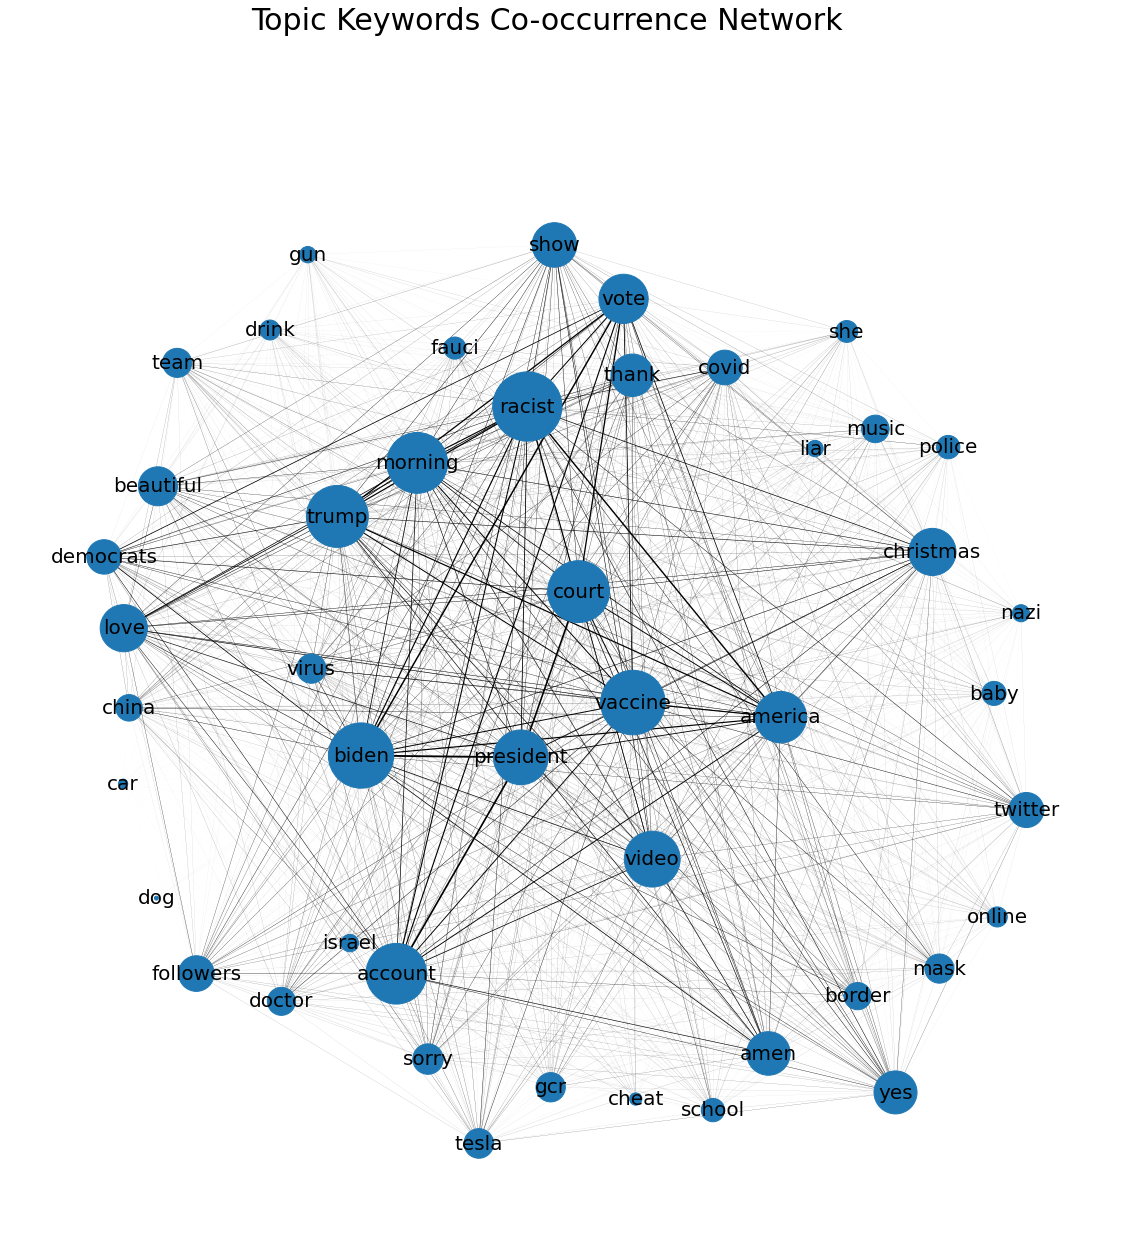

In [238]:
plt.subplots(figsize=(20,20))

node_scalar = 800
edge_scalar = 15
sizes = [x[1]*node_scalar for x in updated_node_order]
widths = [x*edge_scalar for x in updated_again_edges]

#draw the graph
pos = nx.spring_layout(G, k=0.42, iterations=17)

nx.draw(G, pos, with_labels=True, font_size = 20,
        node_size = sizes, width = widths)
plt.suptitle("Topic Keywords Co-occurrence Network", fontsize=30)
# plt.savefig("/content/drive/MyDrive/Knowledge Graphs 2022/semantic network/re_semantic_network.png")